In [1]:
%load_ext autoreload
%autoreload 2

# Information maximiser

Using neural networks, sufficient statistics can be obtained from data by maximising the Fisher information.

The neural network takes some data ${\bf d}$ and maps it to a compressed summary $\mathscr{f}:{\bf d}\to{\bf x}$ where ${\bf x}$ can have the same size as the dimensionality of the parameter space, rather than the data space.

To train the neural network a batch of simulations ${\bf d}_{\sf sim}^{\sf fid}$ created at a fiducial parameter value $\boldsymbol{\theta}^{\rm fid}$ are compressed by the neural network to obtain ${\bf x}_{\sf sim}^{\sf fid}$. From this we can calculate the covariance ${\bf C_\mathscr{f}}$ of the compressed summaries. We learn about model parameter distributions using the derivative of the simulation. This can be provided analytically or numercially using ${\bf d}_{\sf sim}^{\sf fid+}$ created above the fiducial parameter value $\boldsymbol{\theta}^{\sf fid+}$ and ${\bf d}_{\sf sim}^{\sf fid-}$ created below the fiducial parameter value $\boldsymbol{\theta}^{\sf fid-}$. The simulations are compressed using the network and used to find mean of the summaries $\partial\boldsymbol{\mu}_\mathscr{f}/\partial\theta_\alpha\equiv\boldsymbol{\mu}_\mathscr{f},_\alpha$ via the chain rule
$$\frac{\partial\mu}{\partial\theta_\alpha} = \frac{1}{n_{\textrm{sims}}}\sum_{i=1}^{n_{\textrm{sims}}}\frac{\partial{\bf x}_i}{\partial{\bf d}_i}\frac{\partial{\bf d}_i}{\partial\theta_\alpha}.$$
We then use ${\bf C}_\mathscr{f}$ and $\boldsymbol{\mu}_\mathscr{f},_\alpha$ to calculate the Fisher information
$${\bf F}_{\alpha\beta} = \boldsymbol{\mu}_\mathscr{f},^T_{\alpha}{\bf C}^{-1}_\mathscr{f}\boldsymbol{\mu}_\mathscr{f},_{\beta}.$$
We want to maximise the Fisher information, and we want the summaries to be orthogonal so to train the network we minimise the loss function
    $$\Lambda = -\ln|{\bf F}_{\alpha\beta}|+\lambda||{\bf C}_\mathscr{f}-\mathbb{1}||_2,$$
where $\lambda$ is some coupling for the square norm of the network covariance.

When using this code please cite <a href="https://arxiv.org/abs/1802.03537">arXiv:1802.03537</a>.<br><br>
The code in the paper can be downloaded as v1 or v1.1 of the code kept on zenodo:<br><br>
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.1175196.svg)](https://doi.org/10.5281/zenodo.1175196)
<br>

This code is run using<br>
>`python-3.6.6`

>`tensorflow-1.12.0`

>`numpy-1.15.0`

>`tqdm==4.29.0`

Although these precise versions may not be necessary, I have put them here to avoid possible conflicts. 

## Load modules

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import IMNN.IMNN as IMNN
import IMNN.ABC.ABC as ABC
import IMNN.ABC.priors as priors

# Summarising the mean and the variance

For this example we are going to use $n_{\bf d}=10$ data points of a 1D field of Gaussian noise with unknown mean and variance to see if the network can learn to summarise them.<br><br>

The likelihood is given by
$$\mathcal{L} = \prod_i^{n_{\bf d}}\frac{1}{\sqrt{2\pi|\Sigma|}}\exp\left[-\frac{1}{2}\frac{(d_i-\mu)^2}{\Sigma}\right]$$

We can solve this problem analytically, so it is useful to check how well the network does. There is a single sufficient statistic which describes each the mean and the variance, which can be found by finding the maximum of the probability. We find that
$$\sum_i^{n_{\bf d}}d_i = \mu\textrm{ and }\sum_i^{n_{\bf d}}(d_i-\mu)^2=n_{\bf d}\Sigma$$

We can calculate the Fisher information by taking the negative of second derivative of the likelihood taking the expectation by inserting the above relations at examining at some fiducial parameter values
$${\bf F}_{\alpha\beta} = -\left.\left(\begin{array}{cc}\displaystyle-\frac{n_{\bf d}}{\Sigma}&0\\0&\displaystyle-\frac{n_{\bf d}}{2\Sigma^2}\end{array}\right)\right|_{\textrm{fiducial}}.$$
If we choose a fiducial mean of $\mu^{\textrm{fid}}=0$ and variance of $\Sigma^{\textrm{fid}} = 1$ then we obtain a Fisher information matrix of




determinant of the Fisher information 50.000000000000014


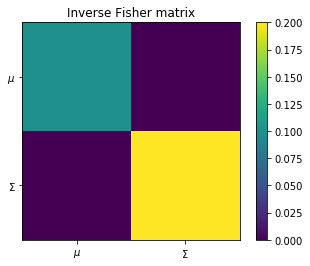

In [3]:
exact_fisher = -np.array([[-10. / 1., 0.], [0. , - 0.5 * 10 / 1.**2.]])
determinant_exact_fisher = np.linalg.det(exact_fisher)
print("determinant of the Fisher information", determinant_exact_fisher)
plt.imshow(np.linalg.inv(exact_fisher))
plt.title("Inverse Fisher matrix")
plt.xticks([0, 1], [r"$\mu$", r"$\Sigma$"])
plt.yticks([0, 1], [r"$\mu$", r"$\Sigma$"])
plt.colorbar();

Let us observe our _real_ data which happens to have true parameters $\mu=3$ and $\Sigma=2$

In [4]:
real_data = np.random.normal(3., np.sqrt(2.), size = (1, 10))

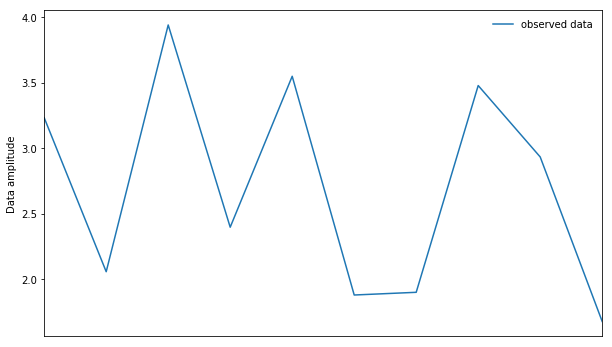

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(real_data[0], label = "observed data")
ax.legend(frameon = False)
ax.set_xlim([0, 9])
ax.set_xticks([])
ax.set_ylabel("Data amplitude");

The posterior distribution for this data (normalised to integrate to 1) is

In [6]:
μ_array = np.linspace(-10, 10, 1000)
Σ_array = np.linspace(0.001, 10, 1000)

parameter_grid = np.array(np.meshgrid(μ_array, Σ_array, indexing = "ij"))
dx = (μ_array[1] - μ_array[0]) * (Σ_array[1] - Σ_array[0])

analytic_posterior = np.exp(-0.5 * (np.sum((real_data[0][:, np.newaxis] - parameter_grid[0, :, 0][np.newaxis, :])**2., axis = 0)[:, np.newaxis] / parameter_grid[1, 0, :][np.newaxis, :] + real_data.shape[1] * np.log(2. * np.pi * parameter_grid[1, 0, :][np.newaxis, :])))
analytic_posterior = analytic_posterior.T / np.sum(analytic_posterior * dx)

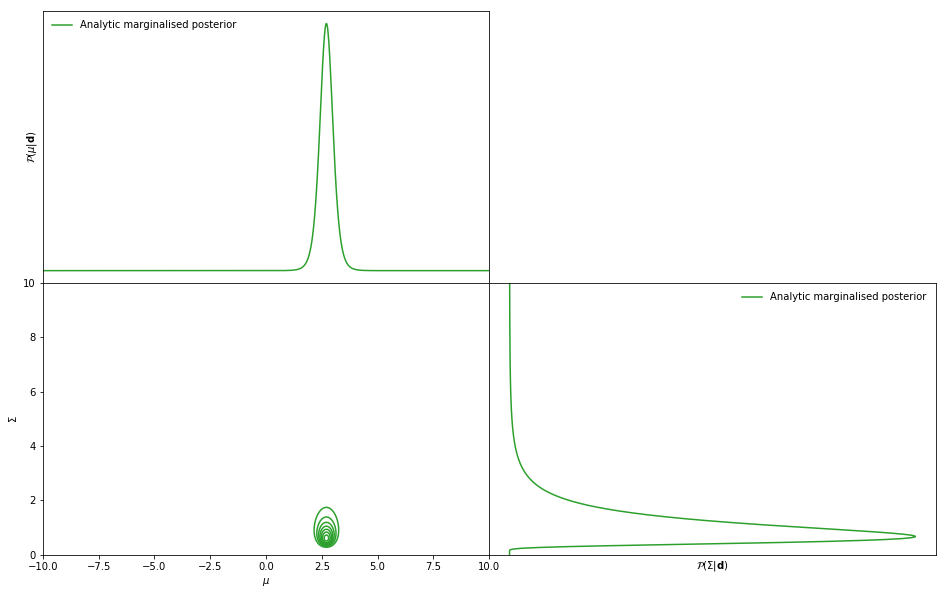

In [7]:
fig, ax = plt.subplots(2, 2, figsize = (16, 10))
plt.subplots_adjust(wspace = 0, hspace = 0)
ax[0, 0].plot(parameter_grid[0, :, 0], np.sum(analytic_posterior, axis = 0), linewidth = 1.5, color = 'C2', label = "Analytic marginalised posterior")
ax[0, 0].legend(frameon = False)
ax[0, 0].set_xlim([-10, 10])
ax[0, 0].set_ylabel('$\\mathcal{P}(\\mu|{\\bf d})$')
ax[0, 0].set_yticks([])
ax[0, 0].set_xticks([])
ax[1, 0].set_xlabel('$\mu$');
ax[1, 0].set_ylim([0, 10])
ax[1, 0].set_ylabel('$\Sigma$')
ax[1, 0].set_xlim([-10, 10])
ax[1, 0].contour(parameter_grid[0, :, 0], parameter_grid[1, 0, :], analytic_posterior, colors = "C2")
ax[1, 1].plot(np.sum(analytic_posterior, axis = 1), parameter_grid[1, 0, :], linewidth = 1.5, color = 'C2', label = "Analytic marginalised posterior")
ax[1, 1].legend(frameon = False)
ax[1, 1].set_ylim([0, 10])
ax[1, 1].set_xlabel('$\\mathcal{P}(\\Sigma|{\\bf d})$')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
ax[0, 1].axis("off");

Now lets see how the information maximising neural network can recover this posterior.

## Generate data

We start by defining a function to generate the data with the correct shape. The shape must be
```
data_shape = None + input shape
```

In [8]:
input_shape = [10]

It is useful to define the generating function so that it only takes in the value of the parameter as its input since the function can then be used for ABC later.<br><br>
The data needs to be generated at a fiducial parameter value and at perturbed values just below and above the fiducial parameter for the numerical derivative. 

In [9]:
θ_fid = np.array([0, 1.])
Δθpm = np.array([0.1, 0.1])

The data at the perturbed values should have the shape
```
perturbed_data_shape = None + number of parameters + input shape
```

The generating function is defined so that the fiducial parameter is passed as a list so that many simulations can be made at once. This is very useful for the ABC function later.

In [10]:
def simulator(θ, seed, simulator_args):
    if seed is not None:
        np.random.seed(seed)
    if len(θ.shape) > 1:
        μ = θ[:, 0]
        Σ = θ[:, 1]
    else:
        μ = 0.
        Σ = θ
    return np.moveaxis(np.random.normal(μ, np.sqrt(Σ), simulator_args["input shape"] + [θ.shape[0]]), -1, 0)

```python
def simulator(θ, seed, simulator_args):
    if seed is not None:
        np.random.seed(seed)
    if len(θ.shape) > 1:
        if θ.shape[1] == 2:
            μ = θ[:, 0]
            Σ = θ[:, 1]
        else:
            μ = θ[:, 0]
            Σ = np.ones_like(μ)
    else:
        μ = θ
        Σ = 1.
    return np.moveaxis(np.random.normal(μ, np.sqrt(Σ), simulator_args["input shape"] + [θ.shape[0]]), -1, 0)
```

### Training data
Enough data needs to be made to approximate the covariance matrix of the output summaries. The number of simulations needed to approximate the covariance is `n_s`. If the data is particularly large then it might not be possible to pass all the data into active memory at once and so several the simulations can be split into batches.

For example if we wanted to make 2000 simulations, but estimate the covariance using 1000 simulations at a time
we would set

In [11]:
n_s = 1000
num_sims = 10 * n_s
seed = np.random.randint(1e6)

The training data can now be made

In [12]:
t = simulator(θ = np.tile(θ_fid, [num_sims, 1]), seed = seed, simulator_args = {"input shape": input_shape})

Ideally we would be able to take the derivative of our simulations with respect to the model parameters. We can indeed do that in this case, but since this is possibly a rare occurance I will show an example where the derivatives are calculated numerically. By suppressing the sample variance between the simulations created at some lower and upper varied parameter values, far fewer simulations are needed.

In [13]:
n_p = 1000
num_partial_sims = 10 * n_p

The sample variance is supressed by choosing the same initial seed when creating the upper and lower simulations.

In [14]:
t_m = simulator(θ = np.tile(θ_fid - np.array([0.1, 0.]), [num_partial_sims, 1]), seed = seed, simulator_args = {"input shape": input_shape})
t_p = simulator(θ = np.tile(θ_fid + np.array([0.1, 0.]), [num_partial_sims, 1]), seed = seed, simulator_args = {"input shape": input_shape})
t_m = np.stack([t_m, simulator(θ = np.tile(θ_fid - np.array([0., 0.1]), [num_partial_sims, 1]), seed = seed, simulator_args = {"input shape": input_shape})], axis = 1)
t_p = np.stack([t_p, simulator(θ = np.tile(θ_fid + np.array([0., 0.1]), [num_partial_sims, 1]), seed = seed, simulator_args = {"input shape": input_shape})], axis = 1)
t_d = (t_p - t_m) / (2. * Δθpm)[np.newaxis, :, np.newaxis]

The fiducial simulations and simulations for the derivative must be collected in a dictionary to be stored in the TensorFlow graph or passed to the training function.

In [15]:
data = {"data": t, "data_d": t_d}

### Test data
We should also make some test data, but here we will use only one combination. This needs adding to the dictionary

In [16]:
num_validation_sims = n_s
num_validation_partial_sims = n_p
seed = np.random.randint(1e6)
tt = simulator(θ = np.tile(θ_fid, [num_validation_sims, 1]), seed = seed, simulator_args = {"input shape": input_shape})
tt_m = simulator(θ = np.tile(θ_fid - np.array([0.1, 0.]), [num_validation_partial_sims, 1]), seed = seed, simulator_args = {"input shape": input_shape})
tt_p = simulator(θ = np.tile(θ_fid + np.array([0.1, 0.]), [num_validation_partial_sims, 1]), seed = seed, simulator_args = {"input shape": input_shape})
tt_m = np.stack([tt_m, simulator(θ = np.tile(θ_fid - np.array([0., 0.1]), [num_validation_partial_sims, 1]), seed = seed, simulator_args = {"input shape": input_shape})], axis = 1)
tt_p = np.stack([tt_p, simulator(θ = np.tile(θ_fid + np.array([0., 0.1]), [num_validation_partial_sims, 1]), seed = seed, simulator_args = {"input shape": input_shape})], axis = 1)
tt_d = (tt_p - tt_m) / (2. * Δθpm)[np.newaxis, :, np.newaxis]
data["validation_data"] = tt
data["validation_data_d"] = tt_d

### Data visualisation
We can plot the data to see what it looks like.

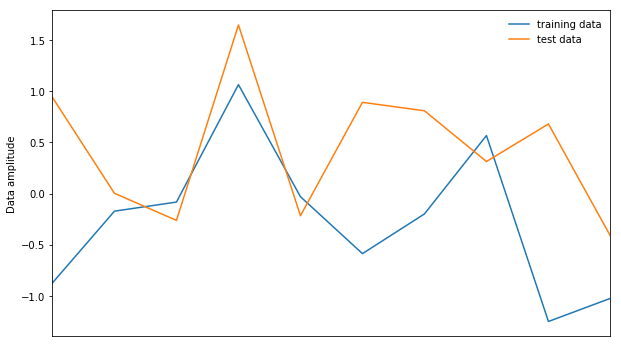

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(data['data'][np.random.randint(num_sims)], label = "training data")
ax.plot(data['validation_data'][np.random.randint(num_validation_sims)], label = "test data")
ax.legend(frameon = False)
ax.set_xlim([0, 9])
ax.set_xticks([])
ax.set_ylabel("Data amplitude");

It is also very useful to plot the upper and lower derivatives to check that the sample variance is actually supressed since the network learns extremely slowly if this isn't done properly.

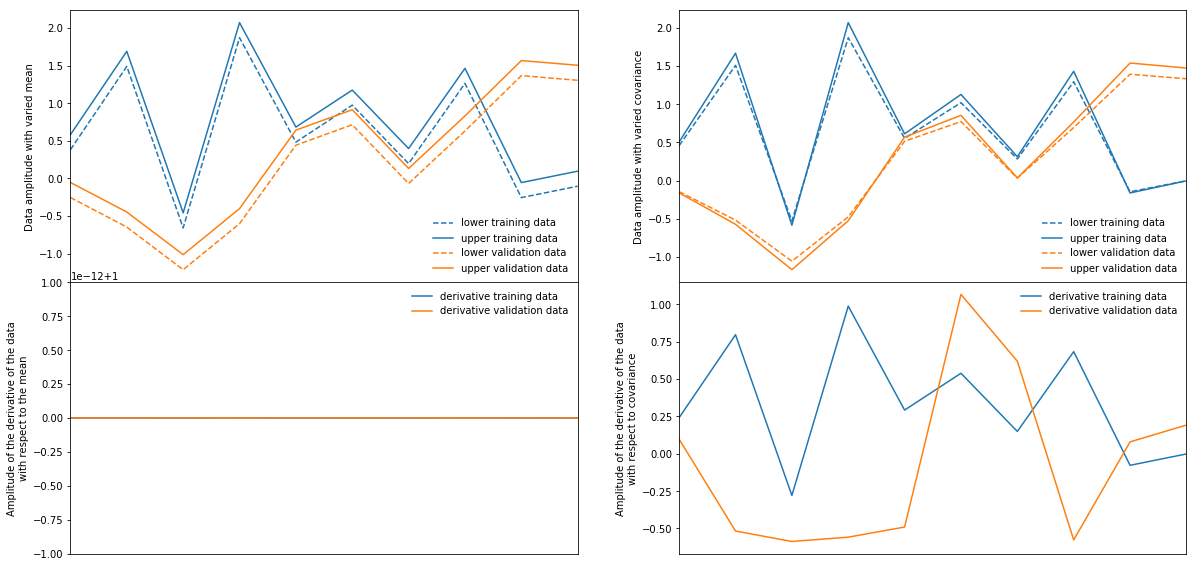

In [18]:
fig, ax = plt.subplots(2, 2, figsize = (20, 10))
plt.subplots_adjust(hspace = 0)
training_index = np.random.randint(num_partial_sims)
test_index = np.random.randint(num_validation_partial_sims)

ax[0, 0].plot(t_m[training_index, 0], label = "lower training data", color = "C0", linestyle = "dashed")
ax[0, 0].plot(t_p[training_index, 0], label = "upper training data", color = "C0")
ax[0, 0].plot(tt_m[test_index, 0], label = "lower validation data", color = "C1", linestyle = "dashed")
ax[0, 0].plot(tt_p[test_index, 0], label = "upper validation data", color = "C1")
ax[0, 0].legend(frameon = False)
ax[0, 0].set_xlim([0, 9])
ax[0, 0].set_xticks([])
ax[0, 0].set_ylabel("Data amplitude with varied mean")
ax[1, 0].plot(data["data_d"][training_index, 0], label = "derivative training data", color = "C0")
ax[1, 0].plot(data["data_d"][test_index, 0], label = "derivative validation data", color = "C1")
ax[1, 0].set_xlim([0, 9])
ax[1, 0].set_xticks([])
ax[1, 0].legend(frameon = False)
ax[1, 0].set_ylabel("Amplitude of the derivative of the data\nwith respect to the mean");

ax[0, 1].plot(t_m[training_index, 1], label = "lower training data", color = "C0", linestyle = "dashed")
ax[0, 1].plot(t_p[training_index, 1], label = "upper training data", color = "C0")
ax[0, 1].plot(tt_m[test_index, 1], label = "lower validation data", color = "C1", linestyle = "dashed")
ax[0, 1].plot(tt_p[test_index, 1], label = "upper validation data", color = "C1")
ax[0, 1].legend(frameon = False)
ax[0, 1].set_xlim([0, 9])
ax[0, 1].set_xticks([])
ax[0, 1].set_ylabel("Data amplitude with varied covariance")
ax[1, 1].plot(data["data_d"][training_index, 1], label = "derivative training data", color = "C0")
ax[1, 1].plot(data["data_d"][test_index, 1], label = "derivative validation data", color = "C1")
ax[1, 1].set_xlim([0, 9])
ax[1, 1].set_xticks([])
ax[1, 1].legend(frameon = False)
ax[1, 1].set_ylabel("Amplitude of the derivative of the data\nwith respect to covariance");

## Initiliase the neural network
### Define network parameters
The network is initialised with a base set of parameters<br>

> `"dtype"` - `int, optional` - 32 or 64 for 32 or 64 bit floats and integers

> `"number of simulations"` - `int` - the number of simulations to use to approximate covariance

> `"number of derivative simulations"` - `int` - the number of derivatives of the simulations to calculate derivative of the mean

> `"fiducial"` - `list` - fiducial parameter values at which to train the network at

> `"number of summaries"` - `int` - number of summaries the network makes from the data

> `"input shape"` - `list` - the shape of the input data

> `"filename"` - `str, optional` - a filename to save/load the graph with

In [19]:
parameters = {
    "dtype": 32,
    "number of simulations": n_s,
    "number of derivative simulations": n_p,
    "fiducial": θ_fid.tolist(),
    "number of summaries": 2,
    "input shape": input_shape,
    "filename": "data/model",
}

In [20]:
tf.reset_default_graph()
n = IMNN.IMNN(parameters = parameters)

## Self-defined network

The information maximising neural network must be a provided with a neural network to optimise. In principle, this should be highly specified to pull out the informative features in the data. All weights should be defined in their own variable scope. Additional tensors which control, say, the dropout or the value of a leaky relu negative gradient can be defined and passed to the training and validation phase using a dictionary.

Below is an example of a network which takes in the data and passes it through a fully connected neural network with 2 hidden layers with 128 neurons in each and outputs two summaries. The activation is leaky relu on the hidden layers and linear on the output.

<br>
<div style="color:red">NOTE THAT BIASES SHOULD NOT BE INCLUDED. THERE IS A MISSING SET OF GRADIENTS WHICH ARE NOT DEFINED IN THE CORE TENSORFLOW CODE.</div>

In [21]:
def build_network(data, **kwargs):
    α = kwargs["activation_parameter"]
    with tf.variable_scope("layer_1"):
        weights = tf.get_variable("weights", shape = [input_shape[-1], 128], initializer = tf.variance_scaling_initializer())
        output = tf.nn.leaky_relu(tf.matmul(data, weights, name = "multiply"), α, name = "output")
    with tf.variable_scope("layer_2"):
        weights = tf.get_variable("weights", shape = [128, 128], initializer = tf.variance_scaling_initializer())
        output = tf.nn.leaky_relu(tf.matmul(output, weights, name = "multiply"), α, name = "output")
    with tf.variable_scope("layer_3"):
        weights = tf.get_variable("weights", shape = (128, n.n_summaries), initializer = tf.variance_scaling_initializer())
        output = tf.identity(tf.matmul(output, weights, name = "multiply"), name = "output")
    return output

Extra tensors such as for dropout, the activation parameter for functions such as leaky relu, or boolean training phase parameter for batch normalisation can be added (with necessary named placeholders). Note that in the network above we only need the activation parameter, but I will leave the extra tensors in the next few cells as an example.

In [22]:
δ = tf.placeholder(dtype = tf.float32, shape = (), name = "dropout_value")
α = tf.placeholder(dtype = tf.float32, shape = (), name = "activation_parameter")
ϕ = tf.placeholder(dtype = tf.bool, shape = (), name = "training_phase")

The network needs to be passed to the IMNN module only taking in a single tensor, as such we should use a lambda function passing through the tensors that we want.

In [23]:
network = lambda x: build_network(x, activation_parameter = α, dropout_value = δ, training_phase = ϕ)

And now the tensor names are stored in training and validation dictionaries with their values to be called during training and validation.

In [24]:
training_dictionary = {"dropout_value:0": 0.8,
                       "activation_parameter:0": 0.01,
                       "training_phase:0": True,
                       }

validation_dictionary = {"dropout_value:0": 1.,
                         "activation_parameter:0": 0.01,
                         "training_phase:0": False,
                         }

There is a very limited network building ability which can be called to build simple networks including fully connected and 1D, 2D and 3D convolutional. All weights are initialised using He initialisation. A limited number of activation functions can be specified (functions that do not need extra parameters), such as `tanh`, `sigmoid`, `relu`, `elu`. The network architecture is described using a list. Each element of the list is a hidden layer. A dense layer can be made using an integer where thet value indicates the number of neurons. A convolutional layer can be built by using a list where the first element is an integer where the number describes the number of filters, the second element is a list of the kernel size in the x and y directions, the third elemnet is a list of the strides in the x and y directions and the final element is string of 'SAME' or 'VALID' which describes the padding prescription.

```python
automatic_network = {
    "activation function" : tf.nn.relu,
    "hidden layers" : [128, 128]
}
```

<div style="color:red">This is still under (slow) development - it would be better to provide your own network because you'll know more about your data!</div>

## Setup the graph
The graph can now be setup easily by passing the network to the setup function.

In [25]:
n.setup(network = network)

saving the graph as data/model.meta


The data can be preloaded to the graph by passing the dictionary to the setup function
```python
n.setup(network = network, load_data = data)
```

## Train the network
The training can now be performed by passing the number of weight and bias updates to perform, the learning rate, how many simulations to pass through the network at once and the number of simulations, number of derivatives of the simulations for training and validation, the dictionaries for training and validation tensors if they are used in the network, the data if it hasn't been preloaded to the network and whether to run the history object.
The strength of the coupling to the covariance regulariser can be passed using the `constraint_strength` keyword (although it is automatically set to 2). This may need to be changed depending on the size of the Fisher information.

Automatically, the training function can be rerun to continue training the network further.

In [111]:
updates = 500
at_once = 1000
learning_rate = 1e-3

n.train(updates, at_once, learning_rate,
        constraint_strength = 2.,
        training_dictionary = training_dictionary, 
        validation_dictionary = validation_dictionary, 
        get_history = True, data = data, restart = False, diagnostics = True)

The network can also be reinitialised before training if something goes wrong by running
```python
n.train(updates, at_once, learning_rate, constraint_strength = 2., training_dictionary = training_dictionary, validation_dictionary = validation_dictionary, get_history = True, data = data, restart = True)
```
Diagnostics can be collected, including the values of the weights and gradients at every epoch, the value of the gradient of the loss function and the determinant of the covariance. Note that this will make the network take a lot longer to train. This option is selected using
```python
n.train(updates, at_once, learning_rate, constraint_strength = 2., training_dictionary = training_dictionary, validation_dictionary = validation_dictionary, get_history = True, data = data, restart = False, diagnostics = True)
```


If run then the history object will contain the value of the determinant of the Fisher information from the training and the validation data.

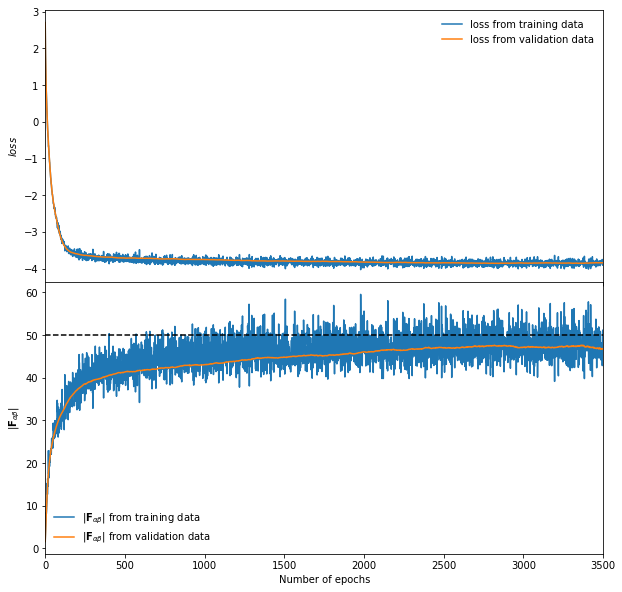

In [112]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize = (10, 10))
plt.subplots_adjust(hspace = 0)
epochs = np.arange(1, len(n.history["det F"]) + 1)
ax[0].plot(epochs, n.history["loss"], label = 'loss from training data')
ax[0].plot(epochs, n.history["test loss"], label = 'loss from validation data')
ax[0].legend(frameon = False)
ax[0].set_xlim([1, epochs[-1]])
ax[0].set_ylabel(r"$loss$")
ax[1].plot(epochs, n.history["det F"], label = r'$|{\bf F}_{\alpha\beta}|$ from training data')
ax[1].plot(epochs, n.history["det test F"], label = r'$|{\bf F}_{\alpha\beta}|$ from validation data')
ax[1].legend(frameon = False)
ax[1].axhline(determinant_exact_fisher, color = "black", linestyle = "dashed")
ax[1].set_xlim([1, epochs[-1]])
ax[1].set_ylabel(r"$|{\bf F}_{\alpha\beta}|$")
ax[1].set_xlabel("Number of epochs");

Since we collected the diagnostics we can plot the covariance

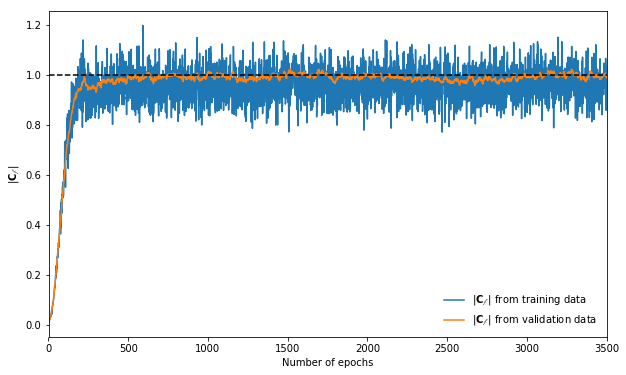

In [113]:
fig, ax = plt.subplots(1, 1, sharex = True, figsize = (10, 6))
ax.plot(epochs, n.diagnostics["det C"], label = r'$|{\bf C}_\mathscr{f}|$ from training data')
ax.plot(epochs, n.diagnostics["det test C"], label = r'$|{\bf C}_\mathscr{f}|$ from validation data')
ax.axhline(1, color = "black", linestyle = "dashed")
ax.legend(frameon = False)
ax.set_xlim([1, epochs[-1]])
ax.set_ylabel(r"$|{\bf C}_\mathscr{f}|$")
ax.set_xlabel("Number of epochs");

We'll also plot the weights from the first neuron in each layer to every neuron in the next layer (eventhough it's not particularly useful in this case)

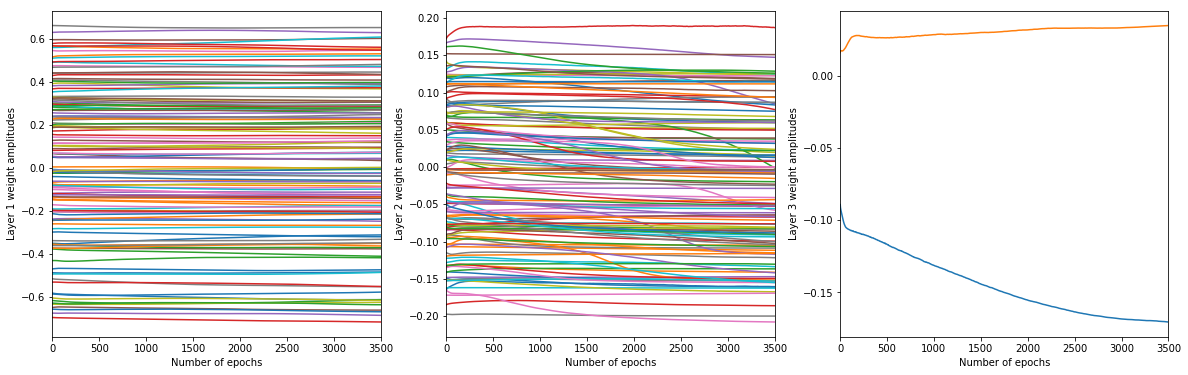

In [114]:
fig, ax = plt.subplots(1, 3, sharex = True, figsize = (20, 6))
end = len(n.diagnostics["weights"][0][:, 0, 0])
ax[0].plot(epochs, n.diagnostics["weights"][0][:end, 0, :]);
ax[0].set_ylabel("Layer 1 weight amplitudes");
ax[0].set_xlabel("Number of epochs");
ax[0].set_xlim([1, epochs[-1]])
ax[1].plot(epochs, n.diagnostics["weights"][1][:end, 0, :]);
ax[1].set_ylabel("Layer 2 weight amplitudes");
ax[1].set_xlabel("Number of epochs");
ax[1].set_xlim([1, epochs[-1]])
ax[2].plot(epochs, n.diagnostics["weights"][2][:end, 0, :]);
ax[2].set_xlim([1, epochs[-1]])
ax[2].set_ylabel("Layer 3 weight amplitudes");
ax[2].set_xlabel("Number of epochs");

And their corresponding gradients are

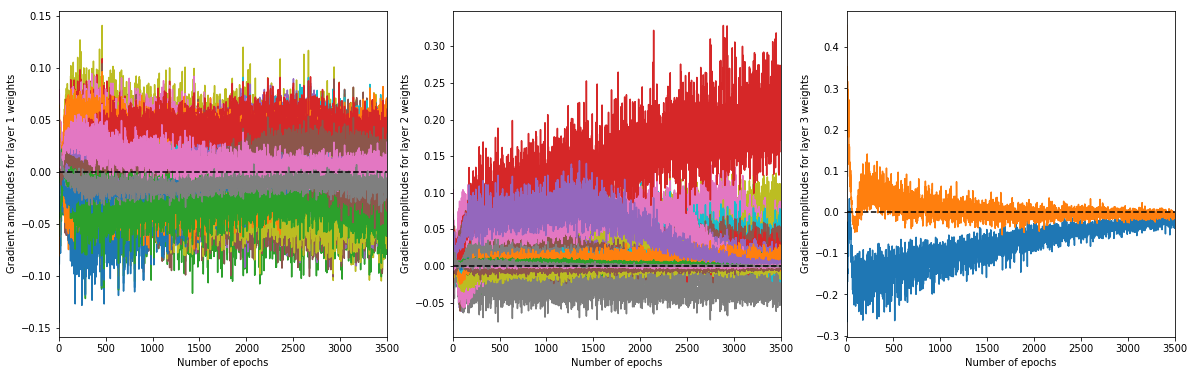

In [115]:
fig, ax = plt.subplots(1, 3, sharex = True, figsize = (20, 6))
ax[0].plot(epochs, n.diagnostics["gradients"][0][:end, 0, :])
ax[0].axhline(0, color = "black", linestyle = "dashed")
ax[0].set_ylabel("Gradient amplitudes for layer 1 weights")
ax[0].set_xlabel("Number of epochs");
ax[0].set_xlim([1, epochs[-1]])
ax[1].plot(epochs, n.diagnostics["gradients"][1][:end, 0, :])
ax[1].axhline(0, color = "black", linestyle = "dashed")
ax[1].set_ylabel("Gradient amplitudes for layer 2 weights")
ax[1].set_xlabel("Number of epochs");
ax[1].set_xlim([1, epochs[-1]])
ax[2].plot(epochs, n.diagnostics["gradients"][2][:end, 0, :])
ax[2].axhline(0, color = "black", linestyle = "dashed")
ax[2].set_ylabel("Gradient amplitudes for layer 3 weights");
ax[2].set_xlim([1, epochs[-1]])
ax[2].set_xlabel("Number of epochs");

And finally, the value of the gradient of the loss function

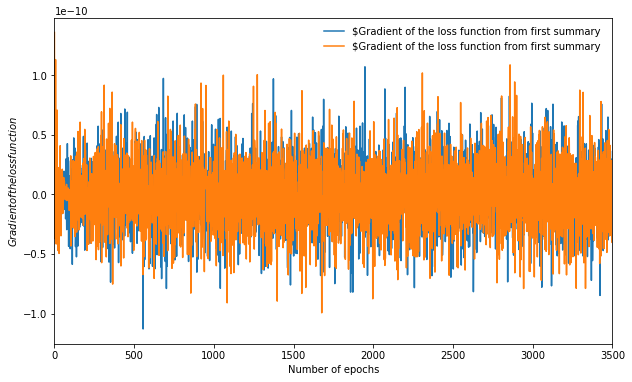

In [116]:
fig, ax = plt.subplots(1, 1, sharex = True, figsize = (10, 6))
ax.plot(epochs, np.mean(n.diagnostics["fisher gradient"], axis = 1)[:, 0], label = r'$Gradient of the loss function from first summary ')
ax.plot(epochs, np.mean(n.diagnostics["fisher gradient"], axis = 1)[:, 1], label = r'$Gradient of the loss function from first summary ')
ax.legend(frameon = False)
ax.set_xlim([1, epochs[-1]])
ax.set_ylabel(r"$Gradient of the loss function$")
ax.set_xlabel("Number of epochs");

## Resetting the network
If you need to reset the weights for any reason, and you don't want to run the training function with `restart = True`, then you can call
```python
n.reinitialise_session()
```

## Saving the network

If you don't initialise the network with a save name you can save the network as a `TensorFlow` `meta` graph. For example saving the model in the directory `./data` called `saved_model.meta` can be done using the function
```python
n.save_network(filename = "data/saved_model", first_time = True)
```
If `save file` is passed with a correct file name when initialising the module then the initialised network will be saved by
```python
n.begin_session()
```
and then saved at the end of training.

## Loading the network

You can load the network from a `TensorFlow` `meta` graph (from `/.data/saved_model.meta`) using the same parameter dictionary as used when originally training the network and then running
```python
n = IMNN(parameters = parameters)
n.restore_network()
```
Training can be continued after restoring the model - although the Adam optimiser might need to reacquaint itself.

## Approximate Bayesian computation

We can now do ABC (or PMC-ABC) with our calculated summary. From the samples we create simulations at each parameter value and feed each simulation through the network to get summaries. The summaries are compared to the summary of the real data to find the distances which can be used to accept or reject points.

We start by defining our prior as a truncated Gaussian (uniform is also available). The uniform function is taken from delfi by Justin Alsing.

We are going to choose the mean value of the variance to be 1 with a variance of the variance of 4 cut at 0 and 10.

In [117]:
prior = priors.TruncatedGaussian(np.array([0., 1.]), np.array([[10., 0.], [0., 10.]]), np.array([-10., 0.]), np.array([10., 10.]))

The ABC module takes in the _observed_ data, the prior and the TF session. It also takes in the simulator and its arguments and the validation dictionary which needs to be passed to the graph.

In [118]:
abc = ABC.ABC(real_data = real_data, prior = prior, sess = n.sess, get_compressor = n.get_compressor, simulator = simulator, seed = None, simulator_args = {"input shape": input_shape}, dictionary = validation_dictionary)

## Gaussian approximation
Before running all the simulations need for approximate Bayesian computation, we can get the Gaussian approximation of the posterior from the MLE and the inverse Fisher information.

maximum likelihood estimate [2.5744095 5.815166 ]
determinant of the Fisher information 46.824364


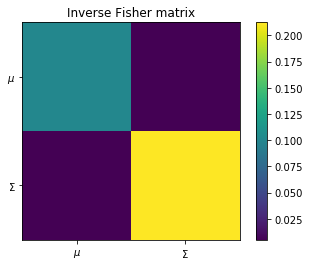

In [119]:
print("maximum likelihood estimate", abc.MLE[0])
print("determinant of the Fisher information", np.linalg.det(abc.fisher))
plt.imshow(np.linalg.inv(abc.fisher))
plt.title("Inverse Fisher matrix")
plt.xticks([0, 1], [r"$\mu$", r"$\Sigma$"])
plt.yticks([0, 1], [r"$\mu$", r"$\Sigma$"])
plt.colorbar();

In [120]:
gaussian_approximation, grid = abc.gaussian_approximation(gridsize = 100)

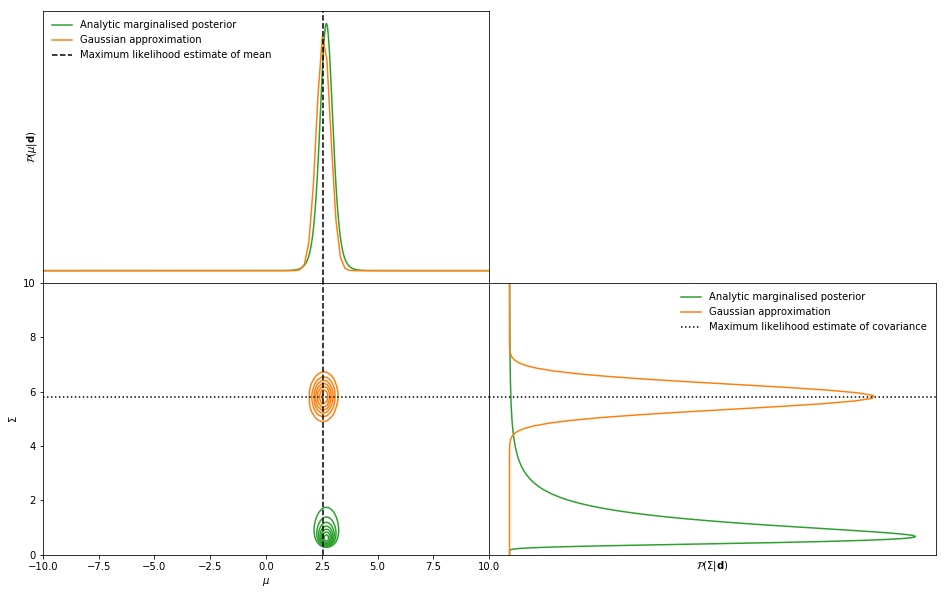

In [121]:
fig, ax = plt.subplots(2, 2, figsize = (16, 10))
plt.subplots_adjust(wspace = 0, hspace = 0)
ax[0, 0].plot(parameter_grid[0, :, 0], np.sum(analytic_posterior * (parameter_grid[0, 1, 0] - parameter_grid[0, 0, 0]), axis = 0), linewidth = 1.5, color = 'C2', label = "Analytic marginalised posterior")
ax[0, 0].plot(grid[0, :, 0], np.sum(gaussian_approximation * (grid[0, 1, 0] - grid[0, 0, 0]), axis = 0), color = "C1", label = "Gaussian approximation")
ax[0, 0].axvline(abc.MLE[0, 0], linestyle = "dashed", color = "black", label = "Maximum likelihood estimate of mean")
ax[0, 0].legend(frameon = False)
ax[0, 0].set_xlim([-10, 10])
ax[0, 0].set_ylabel('$\\mathcal{P}(\\mu|{\\bf d})$')
ax[0, 0].set_yticks([])
ax[0, 0].set_xticks([])
ax[1, 0].set_xlabel('$\mu$');
ax[1, 0].set_ylim([0, 10])
ax[1, 0].set_ylabel('$\Sigma$')
ax[1, 0].set_xlim([-10, 10])
ax[1, 0].contour(parameter_grid[0, :, 0], parameter_grid[1, 0, :], analytic_posterior, colors = "C2")
ax[1, 0].contour(grid[0, :, 0], grid[1, 0, :], gaussian_approximation, colors = "C1")
ax[1, 0].axvline(abc.MLE[0, 0], linestyle = "dashed", color = "black", label = "Maximum likelihood estimate of mean")
ax[1, 0].axhline(abc.MLE[0, 1], linestyle = "dotted", color = "black", label = "Maximum likelihood estimate of covariance")
ax[1, 1].plot(np.sum(analytic_posterior * (parameter_grid[1, 0, 1] - parameter_grid[1, 0, 0]), axis = 1), parameter_grid[1, 0, :], linewidth = 1.5, color = 'C2', label = "Analytic marginalised posterior")
ax[1, 1].plot(np.sum(gaussian_approximation * (grid[1, 0, 1] - grid[1, 0, 0]), axis = 1), grid[1, 0, :], color = "C1", label = "Gaussian approximation")
ax[1, 1].axhline(abc.MLE[0, 1], linestyle = "dotted", color = "black", label = "Maximum likelihood estimate of covariance")
ax[1, 1].legend(frameon = False)
ax[1, 1].set_ylim([0, 10])
ax[1, 1].set_xlabel('$\\mathcal{P}(\\Sigma|{\\bf d})$')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
ax[0, 1].axis("off");

We can see that the maximum likelihood estimate for the mean is almost perfect whilst it is incorrect for the variance. However, we can now see the ABC does in its place.

### ABC
The most simple ABC takes the number of draws and a switch to state whether to run all the simulations in parallel or sequentially. The full simulations can also be saved by passing a file name. The draws are stored in the class attribute `ABC_dict`.

In [122]:
abc.ABC(draws = 100000, at_once = True, save_sims = None, MLE = True)

In ABC, draws are accepted if the distance between the simulation summary and the simulation of the real data are "close", i.e. smaller than some ϵ value, which is chosen somewhat arbitrarily.

In [123]:
ϵ = 2.
accept_indices = np.argwhere(abc.ABC_dict["distances"] < ϵ)[:, 0]
reject_indices = np.argwhere(abc.ABC_dict["distances"] >= ϵ)[:, 0]
print("Number of accepted samples = ", accept_indices.shape[0])

Number of accepted samples =  1223


### Plot samples
We can plot the output samples and the histogram of the accepted samples, which should peak around `θ = 1` (where we generated the real data). The monotonic function of all the output samples shows that the network has learned how to summarise the data.

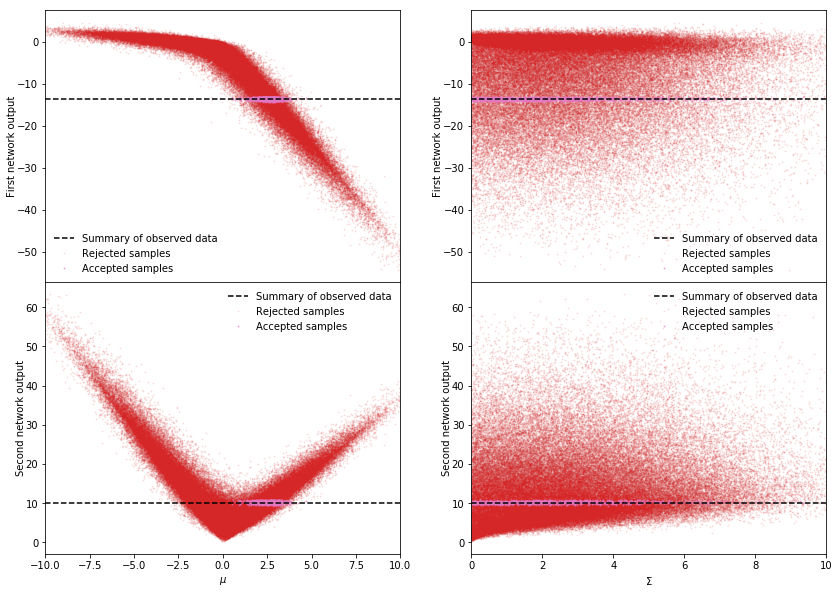

In [124]:
fig, ax = plt.subplots(2, 2, figsize = (14, 10))
plt.subplots_adjust(hspace = 0, wspace = 0.2)
ax[0, 0].scatter(abc.ABC_dict["parameters"][reject_indices, 0], abc.ABC_dict["summaries"][reject_indices, 0], s = 1, alpha = 0.1, label = "Rejected samples", color = "C3")
ax[0, 0].scatter(abc.ABC_dict["parameters"][accept_indices, 0] , abc.ABC_dict["summaries"][accept_indices, 0], s = 1, label = "Accepted samples", color = "C6", alpha = 0.5)
ax[0, 0].axhline(abc.summary[0, 0], color = 'black', linestyle = 'dashed', label = "Summary of observed data")
ax[0, 0].legend(frameon=False)
ax[0, 0].set_ylabel('First network output', labelpad = 0)
ax[0, 0].set_xlim([-10, 10])
ax[0, 0].set_xticks([])
ax[1, 0].scatter(abc.ABC_dict["parameters"][reject_indices, 0], abc.ABC_dict["summaries"][reject_indices, 1], s = 1, alpha = 0.1, label = "Rejected samples", color = "C3")
ax[1, 0].scatter(abc.ABC_dict["parameters"][accept_indices, 0] , abc.ABC_dict["summaries"][accept_indices, 1], s = 1, label = "Accepted samples", color = "C6", alpha = 0.5)
ax[1, 0].axhline(abc.summary[0, 1], color = 'black', linestyle = 'dashed', label = "Summary of observed data")
ax[1, 0].legend(frameon=False)
ax[1, 0].set_ylabel('Second network output', labelpad = 0)
ax[1, 0].set_xlim([-10, 10])
ax[1, 0].set_xlabel("$\mu$")
ax[0, 1].scatter(abc.ABC_dict["parameters"][reject_indices, 1], abc.ABC_dict["summaries"][reject_indices, 0], s = 1, alpha = 0.1, label = "Rejected samples", color = "C3")
ax[0, 1].scatter(abc.ABC_dict["parameters"][accept_indices, 1] , abc.ABC_dict["summaries"][accept_indices, 0], s = 1, label = "Accepted samples", color = "C6", alpha = 0.5)
ax[0, 1].axhline(abc.summary[0, 0], color = 'black', linestyle = 'dashed', label = "Summary of observed data")
ax[0, 1].legend(frameon=False)
ax[0, 1].set_ylabel('First network output', labelpad = 0)
ax[0, 1].set_xlim([0, 10])
ax[0, 1].set_xticks([])
ax[1, 1].scatter(abc.ABC_dict["parameters"][reject_indices, 1], abc.ABC_dict["summaries"][reject_indices, 1], s = 1, alpha = 0.1, label = "Rejected samples", color = "C3")
ax[1, 1].scatter(abc.ABC_dict["parameters"][accept_indices, 1] , abc.ABC_dict["summaries"][accept_indices, 1], s = 1, label = "Accepted samples", color = "C6", alpha = 0.5)
ax[1, 1].axhline(abc.summary[0, 1], color = 'black', linestyle = 'dashed', label = "Summary of observed data")
ax[1, 1].legend(frameon=False)
ax[1, 1].set_ylabel('Second network output', labelpad = 0)
ax[1, 1].set_xlim([0, 10])
ax[1, 1].set_xlabel("$\Sigma$");

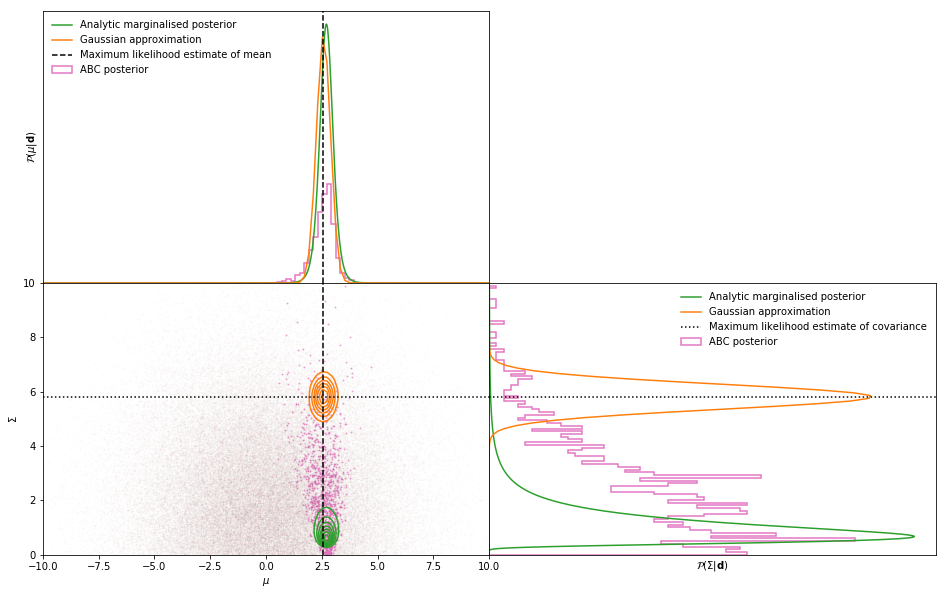

In [125]:
fig, ax = plt.subplots(2, 2, figsize = (16, 10))
plt.subplots_adjust(wspace = 0, hspace = 0)
ax[0, 0].plot(parameter_grid[0, :, 0], np.sum(analytic_posterior * (parameter_grid[0, 1, 0] - parameter_grid[0, 0, 0]), axis = 0), linewidth = 1.5, color = 'C2', label = "Analytic marginalised posterior")
ax[0, 0].plot(grid[0, :, 0], np.sum(gaussian_approximation * (grid[0, 1, 0] - grid[0, 0, 0]), axis = 0), color = "C1", label = "Gaussian approximation")
ax[0, 0].hist(abc.ABC_dict["parameters"][accept_indices, 0], np.linspace(-10, 10, 100), histtype = u'step', density = True, linewidth = 1.5, color = "C6", label = "ABC posterior");
ax[0, 0].axvline(abc.MLE[0, 0], linestyle = "dashed", color = "black", label = "Maximum likelihood estimate of mean")
ax[0, 0].legend(frameon = False)
ax[0, 0].set_xlim([-10, 10])
ax[0, 0].set_ylabel('$\\mathcal{P}(\\mu|{\\bf d})$')
ax[0, 0].set_yticks([])
ax[0, 0].set_xticks([])
ax[1, 0].set_xlabel('$\mu$');
ax[1, 0].set_ylim([0, 10])
ax[1, 0].set_ylabel('$\Sigma$')
ax[1, 0].set_xlim([-10, 10])
ax[1, 0].scatter(abc.ABC_dict["parameters"][accept_indices, 0], abc.ABC_dict["parameters"][accept_indices, 1], color = "C6", s = 1, alpha = 0.5)
ax[1, 0].scatter(abc.ABC_dict["parameters"][reject_indices, 0], abc.ABC_dict["parameters"][reject_indices, 1], color = "C3", s = 1, alpha = 0.01)
ax[1, 0].contour(parameter_grid[0, :, 0], parameter_grid[1, 0, :], analytic_posterior, colors = "C2")
ax[1, 0].contour(grid[0, :, 0], grid[1, 0, :], gaussian_approximation, colors = "C1")
ax[1, 0].axvline(abc.MLE[0, 0], linestyle = "dashed", color = "black", label = "Maximum likelihood estimate of mean")
ax[1, 0].axhline(abc.MLE[0, 1], linestyle = "dotted", color = "black", label = "Maximum likelihood estimate of covariance")
ax[1, 1].hist(abc.ABC_dict["parameters"][accept_indices, 1], np.linspace(0, 10, 100), histtype = u'step', orientation="horizontal", density = True, linewidth = 1.5, color = "C6", label = "ABC posterior");
ax[1, 1].plot(np.sum(analytic_posterior * (parameter_grid[1, 0, 1] - parameter_grid[1, 0, 0]), axis = 1), parameter_grid[1, 0, :], linewidth = 1.5, color = 'C2', label = "Analytic marginalised posterior")
ax[1, 1].plot(np.sum(gaussian_approximation * (grid[1, 0, 1] - grid[1, 0, 0]), axis = 1), grid[1, 0, :], color = "C1", label = "Gaussian approximation")
ax[1, 1].axhline(abc.MLE[0, 1], linestyle = "dotted", color = "black", label = "Maximum likelihood estimate of covariance")
ax[1, 1].legend(frameon = False)
ax[1, 1].set_ylim([0, 10])
ax[1, 1].set_xlabel('$\\mathcal{P}(\\Sigma|{\\bf d})$')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
ax[0, 1].axis("off");

We now get samples from the posterior disrtibution which is not too far from the analytic posterior, and is at least unbiased. However, many samples are rejected to achieve this, and the rejection is defined somewhat arbitrarily, making it very computationally heavy and uncertain. We can improve on this using a PMC.

## PMC-ABC
Population Monte Carlo ABC is a way of reducing the number of draws by first sampling from a prior, accepting the closest 75% of the samples and weighting all the rest of the samples to create a new proposal distribution. The furthest 25% of the original samples are redrawn from the new proposal distribution. The furthest 25% of the simulation summaries are continually rejected and the proposal distribution updated until the number of draws needed accept all the 25% of the samples is much greater than this number of samples. This ratio is called the criterion. 

If we want 1000 samples from the approximate distribution at the end of the PMC we need to set `posterior = 1000`. The initial random draw (as in ABC above) initialises with `draws`, the larger this is the better proposal distribution will be on the first iteration.

The `PMC` can be continued by running again with a smaller criterion. 

In [126]:
abc.PMC(draws = 2000, posterior = 2000, criterion = 0.01, at_once = True, save_sims = None, MLE = True) 

To restart the PMC from scratch then one can run
```python
abc.PMC(draws = 1000, posterior = 1000, criterion = 0.01, at_once = True, save_sims = None, restart = True) 
```

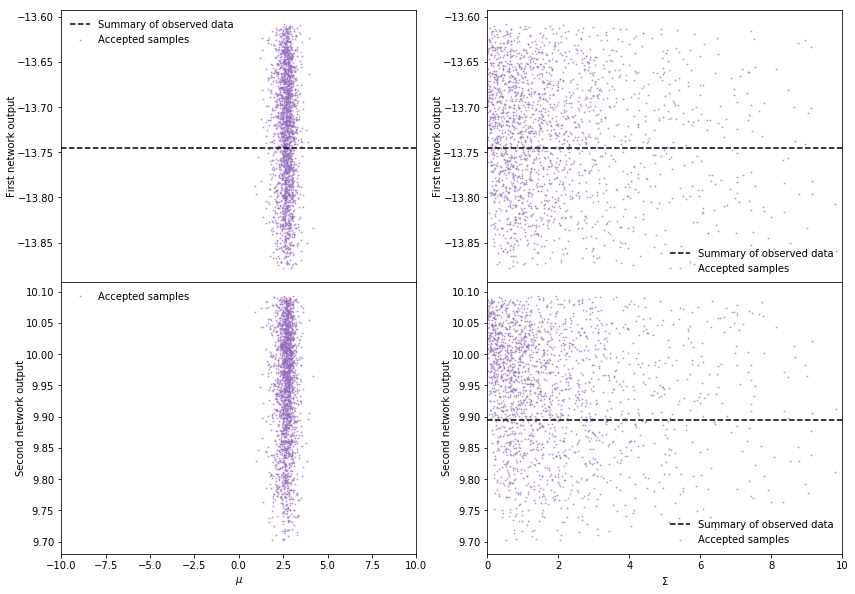

In [127]:
fig, ax = plt.subplots(2, 2, figsize = (14, 10))
plt.subplots_adjust(hspace = 0, wspace = 0.2)
ax[0, 0].scatter(abc.PMC_dict["parameters"][:, 0] , abc.PMC_dict["summaries"][:, 0], s = 1, label = "Accepted samples", color = "C4", alpha = 0.5)
ax[0, 0].axhline(abc.summary[0, 0], color = 'black', linestyle = 'dashed', label = "Summary of observed data")
ax[0, 0].legend(frameon=False)
ax[0, 0].set_ylabel('First network output', labelpad = 0)
ax[0, 0].set_xlim([-10, 10])
ax[0, 0].set_xticks([])
ax[1, 0].scatter(abc.PMC_dict["parameters"][:, 0], abc.PMC_dict["summaries"][:, 1], s = 1, alpha = 0.5, label = "Accepted samples", color = "C4")
ax[1, 0].legend(frameon=False)
ax[1, 0].set_ylabel('Second network output', labelpad = 0)
ax[1, 0].set_xlim([-10, 10])
ax[1, 0].set_xlabel("$\mu$")
ax[0, 1].scatter(abc.PMC_dict["parameters"][:, 1], abc.PMC_dict["summaries"][:, 0], s = 1, alpha = 0.5, label = "Accepted samples", color = "C4")
ax[0, 1].axhline(abc.summary[0, 0], color = 'black', linestyle = 'dashed', label = "Summary of observed data")
ax[0, 1].legend(frameon=False)
ax[0, 1].set_ylabel('First network output', labelpad = 0)
ax[0, 1].set_xlim([0, 10])
ax[0, 1].set_xticks([])
ax[1, 1].scatter(abc.PMC_dict["parameters"][:, 1], abc.PMC_dict["summaries"][:, 1], s = 1, alpha = 0.5, label = "Accepted samples", color = "C4")
ax[1, 1].axhline(abc.summary[0, 1], color = 'black', linestyle = 'dashed', label = "Summary of observed data")
ax[1, 1].legend(frameon=False)
ax[1, 1].set_ylabel('Second network output', labelpad = 0)
ax[1, 1].set_xlim([0, 10])
ax[1, 1].set_xlabel("$\Sigma$");

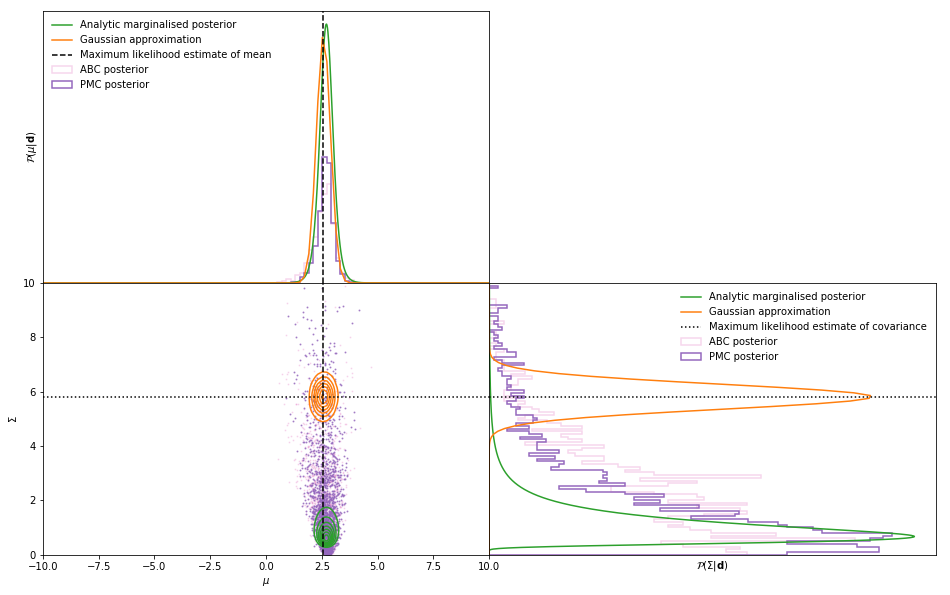

In [128]:
fig, ax = plt.subplots(2, 2, figsize = (16, 10))
plt.subplots_adjust(wspace = 0, hspace = 0)
ax[0, 0].plot(parameter_grid[0, :, 0], np.sum(analytic_posterior * (parameter_grid[0, 1, 0] - parameter_grid[0, 0, 0]), axis = 0), linewidth = 1.5, color = 'C2', label = "Analytic marginalised posterior")
ax[0, 0].plot(grid[0, :, 0], np.sum(gaussian_approximation * (grid[0, 1, 0] - grid[0, 0, 0]), axis = 0), color = "C1", label = "Gaussian approximation")
ax[0, 0].hist(abc.ABC_dict["parameters"][accept_indices, 0], np.linspace(-10, 10, 100), histtype = u'step', density = True, linewidth = 1.5, color = "C6", alpha = 0.3, label = "ABC posterior");
ax[0, 0].hist(abc.PMC_dict["parameters"][:, 0], np.linspace(-10, 10, 100), histtype = u'step', density = True, linewidth = 1.5, color = "C4", label = "PMC posterior");
ax[0, 0].axvline(abc.MLE[0, 0], linestyle = "dashed", color = "black", label = "Maximum likelihood estimate of mean")
ax[0, 0].legend(frameon = False)
ax[0, 0].set_xlim([-10, 10])
ax[0, 0].set_ylabel('$\\mathcal{P}(\\mu|{\\bf d})$')
ax[0, 0].set_yticks([])
ax[0, 0].set_xticks([])
ax[1, 0].set_xlabel('$\mu$');
ax[1, 0].set_ylim([0, 10])
ax[1, 0].set_ylabel('$\Sigma$')
ax[1, 0].set_xlim([-10, 10])
ax[1, 0].scatter(abc.ABC_dict["parameters"][accept_indices, 0], abc.ABC_dict["parameters"][accept_indices, 1], color = "C6", s = 1, alpha = 0.2)
ax[1, 0].scatter(abc.PMC_dict["parameters"][:, 0], abc.PMC_dict["parameters"][:, 1], color = "C4", s = 1, alpha = 0.7)
ax[1, 0].contour(parameter_grid[0, :, 0], parameter_grid[1, 0, :], analytic_posterior, colors = "C2")
ax[1, 0].contour(grid[0, :, 0], grid[1, 0, :], gaussian_approximation, colors = "C1")
ax[1, 0].axvline(abc.MLE[0, 0], linestyle = "dashed", color = "black", label = "Maximum likelihood estimate of mean")
ax[1, 0].axhline(abc.MLE[0, 1], linestyle = "dotted", color = "black", label = "Maximum likelihood estimate of covariance")
ax[1, 1].hist(abc.ABC_dict["parameters"][accept_indices, 1], np.linspace(0, 10, 100), histtype = u'step', orientation="horizontal", density = True, linewidth = 1.5, color = "C6", alpha = 0.3, label = "ABC posterior");
ax[1, 1].plot(np.sum(analytic_posterior * (parameter_grid[1, 0, 1] - parameter_grid[1, 0, 0]), axis = 1), parameter_grid[1, 0, :], linewidth = 1.5, color = 'C2', label = "Analytic marginalised posterior")
ax[1, 1].plot(np.sum(gaussian_approximation * (grid[1, 0, 1] - grid[1, 0, 0]), axis = 1), grid[1, 0, :], color = "C1", label = "Gaussian approximation")
ax[1, 1].hist(abc.PMC_dict["parameters"][:, 1], np.linspace(0, 10, 100), histtype = u'step', orientation="horizontal", density = True, linewidth = 1.5, color = "C4", label = "PMC posterior");
ax[1, 1].axhline(abc.MLE[0, 1], linestyle = "dotted", color = "black", label = "Maximum likelihood estimate of covariance")
ax[1, 1].legend(frameon = False)
ax[1, 1].set_ylim([0, 10])
ax[1, 1].set_xlabel('$\\mathcal{P}(\\Sigma|{\\bf d})$')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
ax[0, 1].axis("off");

We can see that the IMNN can recover great posteriors even when the data is extremely far from the fiducial parameter value at which the network was trained! Woohoo - give yourself a pat on the back!